In [32]:
## Keras version used is old . Refer to link below for syntax questions:
# Refer https://insight.io/github.com/fchollet/keras/blob/1.2.1/keras/layers/normalization.py 

## Essentials
import numpy as np
import imutils
import argparse
import dlib
import cv2
import os                                                                                                             
import random
from PIL import Image
import matplotlib.image as mpimg
from math import ceil
import matplotlib.pyplot as plt
from skimage.feature import hog

## Face Detection essentials
from imutils import face_utils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb

## Keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import ZeroPadding2D

## Analysis
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score

# Add-ons
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback


## Ploting images inside jupyter notebook
%matplotlib inline

## Path Delimiter depending on os
path_delimiter = os.sep

## Face Align function to align any facial image and crop the face region

In [33]:
## Initializing Face Detector 
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

## Initializing Face Aligner
fa = FaceAligner(predictor, desiredFaceWidth=150)

# Face Align Function
def faceAlign(image):
    #image = mpimg.imread(img)
    image = imutils.resize(image, width=150)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 2)
    faceAligned = []
    for rect in rects:
        faceAligned = fa.align(image, gray, rect)
        #print(rect)
        #plt.imshow(faceAligned)
    
    return faceAligned


## Function to list files in directories and subdirectories
 Used for listing all  images in a folder 

In [34]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r  

# Example:
image_paths=list_files('dataset_cropped')

## Label encoder to convert label strings to numbers

In [35]:
## Label Encoder for string Labels

# Finding unique labels
all_labels = [imag.split(path_delimiter)[-2] for imag in image_paths];

## Encoding them
le = preprocessing.LabelEncoder()
le.fit(all_labels)
labels_enc = le.transform(all_labels)

unique_labels = list(le.classes_)
print('Labels: ')
[print(int(le.transform([label])),label) for label in unique_labels];

Labels: 
0 Abhishek Bachan
1 Alex Rodriguez
2 Ali Landry
3 Alyssa Milano
4 Anderson Cooper
5 Anna Paquin
6 Audrey Tautou
7 Barack Obama
8 Ben Stiller
9 Christina Ricci
10 Clive Owen
11 Cristiano Ronaldo
12 Daniel Craig
13 Danny Devito
14 David Duchovny
15 Denise Richards
16 Diane Sawyer


## Data Augmentation

In [36]:
def augment_brightness_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .6+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

## Function to 'read' and 'align' each image as it loads
Makes the CNN model slow as a result

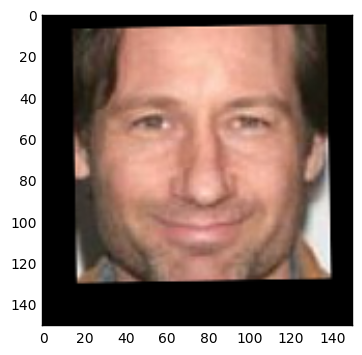

In [374]:
# for data_cropped folder

def read_images(image_paths):
    images = [];
    labels = [];
    for img_path in image_paths:
        try:
            image = faceAlign(mpimg.imread(img_path));
        except:
            continue
        if image is not None and np.shape(np.shape(image)) == (3, ):
            images.append(image)
            labels.append(img_path.split(path_delimiter)[1])
    return images,labels


sample_length = 15
image_paths=list_files('dataset_cropped')
sample_dt=random.sample(image_paths,int(sample_length))
images,labels=read_images(sample_dt)

## Sample for Feature Exploration Later
image = images[0]
plt.imshow(image);

## Thus Aligning images and saving them in 'dataset_aligned' folder

In [37]:
## Send image_paths of the data_cropped folder

def save_align_imgs(image_paths):
    for img_path in image_paths:
        try:
            image = faceAlign(mpimg.imread(img_path));
        except:
            continue
        folder = img_path.split(path_delimiter)[-2]
        filename = img_path.split(path_delimiter)[-1]

        if image is not None and np.shape(np.shape(image)) == (3, ):
            if not os.path.exists('dataset_aligned/'+folder): os.makedirs('dataset_aligned/'+folder)
            cv2.imwrite(("dataset_aligned/{}/{}.jpg".format(folder,filename)),image)    

## Reading Aligned Images directly from folder
Reduces the time CNN model takes to align while training

In [38]:
# read_images fnc for 'data_aligned' images folder

def read_images_align(image_paths , mod_algo = 0):
    images = [];
    labels = [];
    for img_path in image_paths:
        image = mpimg.imread(img_path)
        images.append(image)
        labels.append(img_path.split(path_delimiter)[1])
    
    if mod_algo:
        ## Modified algorithm to augment brightness. Base Model Does not use modified Algorithm
        sz_img = np.array(images).shape[0]
        ind = (np.random.choice(sz_img, int(sz_img/3), replace=False)).astype(int)
        for n in ind:
            images[n] = augment_brightness_images(images[n])
    
    return images,labels

## Data generator function for CNN

Shape of the image array:  (50, 1, 150, 150)
Shape of the image:  (1, 150, 150)
Shape of image after reshaping:  (150, 150)


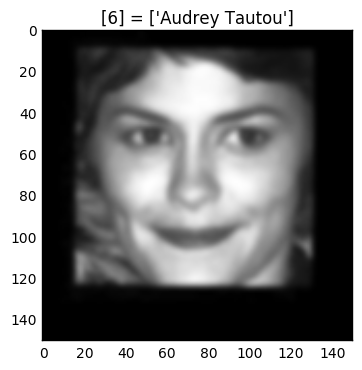

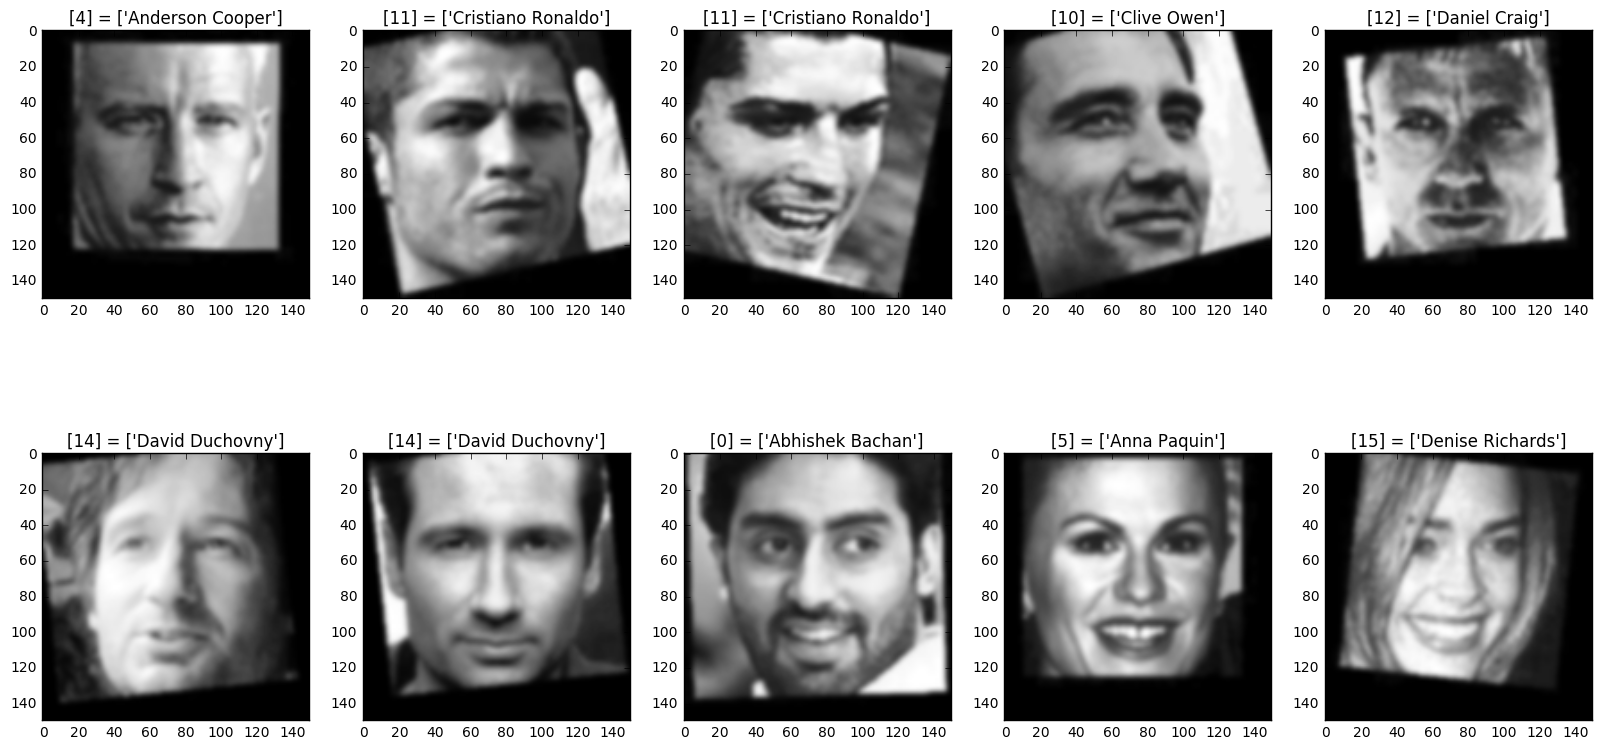

In [42]:
## If setting read_aligned to 0 , change the folder

def data_gen(batch_size=30, read_aligned = 1, folder = 'dataset_aligned'):
    while True:
        
        ## Define the ouput image size desired
        output_img_sz = 150
        
        ## Load images from 'dataset_aligned' folder
        image_paths=list_files(folder)
        
        ## Take random set of data of size ('batch_size' + 10) to avoid images 
        ## that are unable to load or have no face in it
        sample_dt=random.sample(image_paths,int(batch_size)+10)
        
        if read_aligned == 1:
            images,labels = read_images_align(sample_dt,1)
        else:
            images,labels = read_images(sample_dt)
        
        ## Converting them to numpy arrays
        images=np.asarray(images)
        labels=np.asarray(labels)
        
        flipped_img=[];
        blur_grays = [];
        
        for image in images:
            ## Converting to grayscale and Equalizing Histogram
            gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
            gray = cv2.equalizeHist(gray)
            
            ## Resizing the images to output size
            gray = cv2.resize(gray, (output_img_sz, output_img_sz)) 
            
            ## Adding Gaussian Blur to distort the images a bit
            kernel_size = 7 # Must be an odd number (3, 5, 7...)
            blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
            blur_grays.append(blur_gray)
            
            ## Flipping the images
            flipped_img.append(np.fliplr(blur_gray))
        
        ## Appending the Flipped images to 'blur_gray' image array 
        blur_grays = np.append(blur_grays , flipped_img, axis = 0)
        labels = np.append(labels, labels , axis=0)
        
        ## Choosing a random set of images
        ind = np.random.choice(blur_grays.shape[0], batch_size, replace=False)
        blur_grays=blur_grays[ind,:,:]
        labels=le.transform(labels[ind])
        
        ## Converting the colorscale to float32
        blur_grays = blur_grays.astype('float32')
        ## Normalizing
        blur_grays /= 255.
        
        ## Reshaping the image and label arrays and registering as output
        X = np.reshape(blur_grays, [-1,1,output_img_sz,output_img_sz])
        y = np.reshape(labels, [ -1,1])        
           
        yield X,y
   




### Testing the data generator function

sample_images,sample_labels = next(data_gen(50,1))
print('Shape of the image array: ', np.shape(sample_images))

## Selecting random image
sample_choice = random.randint(0,9)
sample_img = sample_images[sample_choice]
print('Shape of the image: ', np.shape(sample_img))

## Reshaping to plot the image correctly
sample_img = np.reshape(sample_img,[np.shape(sample_img)[2],np.shape(sample_img)[2]])
print('Shape of image after reshaping: ', np.shape(sample_img))
plt.figure(1)
plt.imshow(sample_img, cmap = 'gray')
plt.title(str(sample_labels[sample_choice])+' = '+str(le.inverse_transform(sample_labels[sample_choice])));




ind = np.random.choice(sample_images.shape[0], 10, replace=False)


fig = plt.figure(2,figsize=[20,10])


for ix, idx in enumerate(ind):
    plt.subplot(2,5,ix+1)
    sample_img = sample_images[idx]
    sample_img = np.reshape(sample_img,[np.shape(sample_img)[2],np.shape(sample_img)[2]])
    plt.imshow(sample_img, cmap = 'gray')
    plt.title(str(sample_labels[idx])+' = '+str(le.inverse_transform(sample_labels[idx])));

## Image Feature Exploration

### Color Exploration

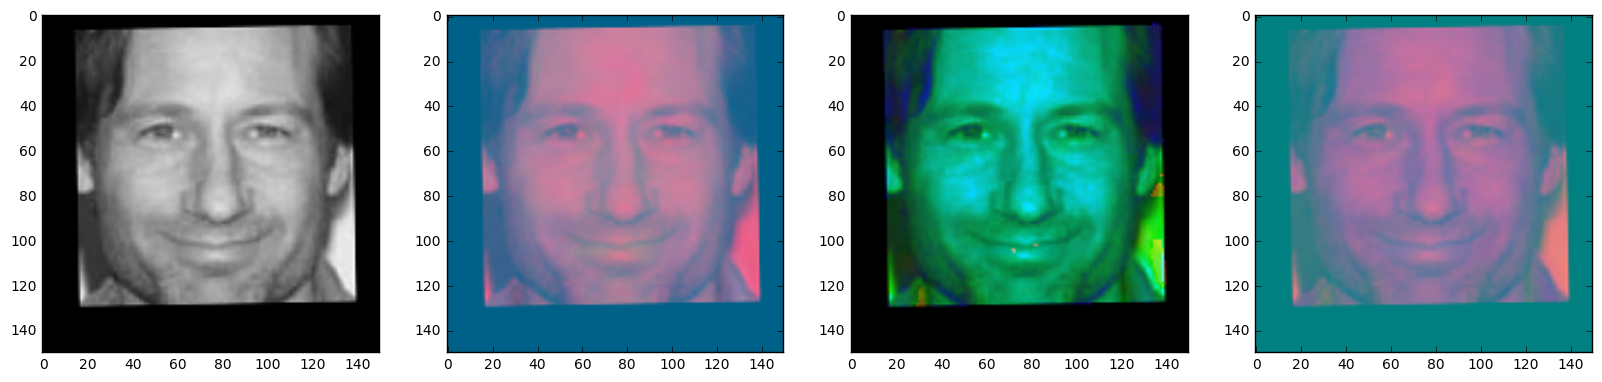

In [375]:
fig = plt.figure(figsize=[20,10])
plt.subplot(241)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),cmap='gray')

plt.subplot(242)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2LUV))

plt.subplot(243)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HLS))

plt.subplot(244)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))

### HOG Feature Exploration

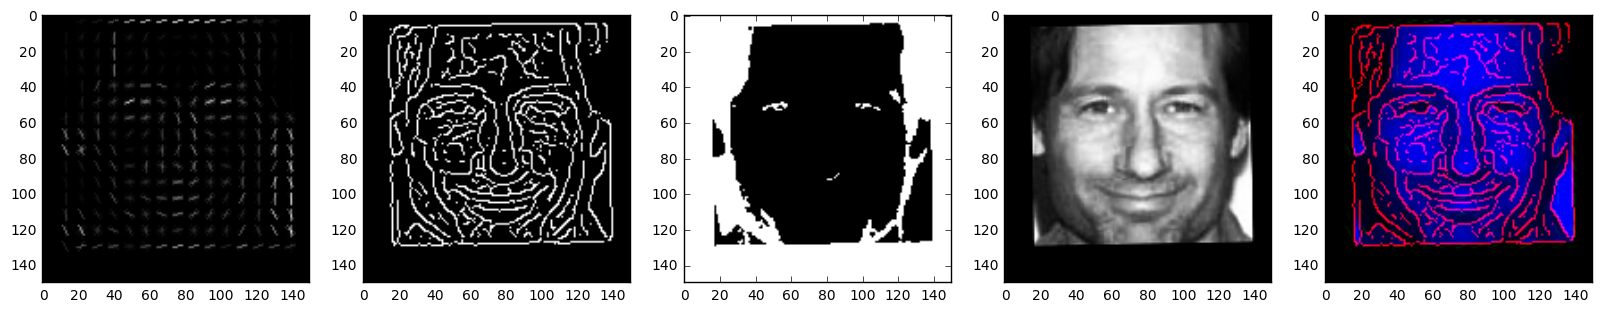

In [377]:

gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
gray = cv2.equalizeHist(gray)
kernel_size = 7 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 1
high_threshold = 20
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


features , hog_img = hog(gray, orientations=9, 
    pixels_per_cell=(9, 9),
    cells_per_block=(5, 5), 
    transform_sqrt=False, 
    visualise=True, feature_vector=True)



fig = plt.figure(figsize=[20,10])
plt.subplot(251)
plt.imshow(hog_img, cmap =  'gray')

plt.subplot(252)
plt.imshow(edges, cmap = 'Greys_r')

plt.subplot(253)
plt.imshow(gray<60, cmap = 'gray')

plt.subplot(254)
plt.imshow(gray, cmap = 'gray')


img2 = np.zeros_like(image)
img2[:,:,0] = edges
img2[:,:,1] = hog_img
img2[:,:,2] = gray

plt.subplot(255)
plt.imshow(img2)

# note to self ... use equalizeHist function for grayscale images

### Attempt to feed feature images to CNN but was not necessary

In [379]:
# Function to create a feature image and feed to CNN

def process_img_feature(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    
    kernel_size = 7 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    low_threshold = 1
    high_threshold = 20
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    features , hog_img = hog(gray, orientations=9, 
    pixels_per_cell=(9, 9),
    cells_per_block=(7,7), 
    transform_sqrt=False, 
    visualise=True, feature_vector=True)
    
    img2 = np.zeros_like(sample_img)
    img2[:,:,0] = edges
    img2[:,:,1] = hog_img
    img2[:,:,2] = gray
    
    return img2

## Base CNN model to train and test 

In [43]:
## Initial Training -  CNN Base Version 1
input_shape=(1, sample_img.shape[0],sample_img.shape[1])

model_base = Sequential()

model_base.add(Conv2D(32, 3, 3, input_shape=input_shape, dim_ordering='th'))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))

model_base.add(Conv2D(32, 3, 3,dim_ordering='th'))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))

model_base.add(Conv2D(64, 3, 3, dim_ordering='th'))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))


model_base.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_base.add(Dense(64))
model_base.add(Activation('relu'))
model_base.add(Dropout(0.5))
model_base.add(Dense(17))
model_base.add(Activation('sigmoid'))

model_base.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)

model_base.summary()
model_base.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,
                         validation_data=gen_valid,nb_val_samples=25, max_q_size=25,
                       verbose=0, callbacks=[TQDMNotebookCallback(leave_inner =True)])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 148, 148)  320         convolution2d_input_8[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 148, 148)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 74, 74)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 72, 72)    9248        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [ ]:
## Training Version 2 and 3
model_base = load_model('modelV2.h5')
batch_size=30
epochs=50
gen_train=data_gen(30)
gen_valid=data_gen(30)

model_base.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,
                         validation_data=gen_valid,nb_val_samples=25, max_q_size=25,
                         verbose=0, callbacks=[TQDMNotebookCallback(leave_inner =True)])

In [ ]:
# Saving the weights
#model_base.save('modelV3.h5')

## Testing the model
### Testing from the database

In [ ]:
## Loading version 3 of model_base
model_base = load_model('modelV3.h5')
test_images,test_labels = next(data_gen(5,0))

In [ ]:

num_images = np.shape(test_images)[0]

plt.figure(figsize=[20,20])

for n_img in range(0,num_images):
    test_img = test_images[n_img]
    test_img_exp = np.reshape(test_img,[150,150])
    ax = plt.subplot(1,num_images,n_img+1)
    plt.imshow(test_img_exp, cmap = 'gray')
    ax.set_title(test_labels[n_img])

#test_img = test_images[0]
#test_img_exp = np.reshape(test_img,[150,150])
#print(np.shape(test_img_exp))
#plt.imshow(test_img_exp, cmap = 'gray')
#print(test_labels[0])

In [ ]:
from sklearn.metrics import f1_score
#test_img = np.reshape(test_img , [-1,1,150,150])
preds = model_base.predict(test_images)

#print(f1_score(test_labels, prediction, average='macro'))
print(np.argmax(preds, axis = 1))


### Testing on a web image

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

## Reading the image
img = []
img_path = 'test_images\Anna Paquin \\ anna_paquin.jpg'
img_label = img_path.split(path_delimiter)[-2]
enc_img_label = le.transform([img_label])

img = mpimg.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


## Detecting faces and cropping
faces = face_cascade.detectMultiScale(gray, 1.3, 2)
if faces.size:
    for (x,y,w,h) in faces:
        #print(x,y,w,h)
        cropped_img =  img[y:y+h, x:x+w]
else:
    print('Face not found')
    
## Aligning the image
aligned_img = faceAlign(cropped_img)
aligned_img=np.asarray(aligned_img)


## Preprocessing the image for the model
gray = cv2.cvtColor(aligned_img,cv2.COLOR_RGB2GRAY)
gray = cv2.equalizeHist(gray)
gray = cv2.resize(gray, (150, 150)) 
kernel_size = 7 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

blur_gray = blur_gray.astype('float32')

blur_gray /= 255.

blur_gray = np.reshape(blur_gray, [-1,1,150,150])

test_img = blur_gray


## Plotting the image
test_img_exp = np.reshape(test_img,[150,150])
plt.imshow(test_img_exp, cmap = 'gray')
plt.title(str(enc_img_label)+' - '+img_label)

In [ ]:
# Predicted Value
preds = model_base.predict(test_img)
enc_label = np.argmax(preds, axis = 1)
label = le.inverse_transform(enc_label)

print(str(enc_label),' - ',label)


## Alexnet Model

In [16]:
def AlexNet(sample_img):
    input_shape = (1, sample_img.shape[0],sample_img.shape[1])
    print(input_shape)
    model_alex = Sequential()
    
    #model_alex.add(Lambda(lambda x:x/255.0-0.50,input_shape=input_shape))
    model_alex.add(Conv2D(96, 11, 11, input_shape=input_shape, dim_ordering='th', border_mode='same', activation='relu', name='conv_1'))
    #model_alex.add(Activation('relu', name='actv_1'))
    model_alex.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2) ,dim_ordering='th', name="maxpool_1"))
    model_alex.add(BatchNormalization())
    print('before zero padding')
    #model_alex.add(ZeroPadding2D((2, 2)))
    
    model_alex.add(Conv2D(128 ,5 ,5 ,dim_ordering='th', border_mode='same', activation='relu', name='conv_2'))
    #model_alex.add(Activation('relu', name='actv_2'))
    model_alex.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2) ,dim_ordering='th', name='maxpool_2'))
    model_alex.add(BatchNormalization())
    #model_alex.add(ZeroPadding2D((1, 1)))    
    
    model_alex.add(Conv2D(384 ,3 ,3 , dim_ordering='th' , border_mode='same', activation='relu', name='conv_3'))
    #model_alex.add(Activation('relu', name='actv_3'))
    #model_alex.add(ZeroPadding2D(padding=(1, 1))) 
    
    model_alex.add(Conv2D(192 ,3 ,3 , dim_ordering='th' , border_mode='same', activation='relu', name='conv_4'))
    #model_alex.add(Activation('relu', name='actv_4'))
    #model_alex.add(ZeroPadding2D(padding=(1, 1))) 
    
    model_alex.add(Conv2D(128 ,3 ,3 , dim_ordering='th' , activation='relu', name='conv_5'))
    #model_alex.add(Activation('relu', name='actv_5'))
    model_alex.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2) ,dim_ordering='th', name='maxpool_5'))
    
    model_alex.add(Flatten(name='flatten'))  
    model_alex.add(Dense(4096, name='dense_1', activation='relu'))
    #model_alex.add(Activation('relu'))
    model_alex.add(Dropout(0.5))
  
    model_alex.add(Dense(4096, name='dense_2', activation='relu'))
    #model_alex.add(Activation('relu'))
    model_alex.add(Dropout(0.5))
    
    model_alex.add(Dense(17,  name='dense_3'))
    model_alex.add(Activation('sigmoid'))
    print('done')
    return model_alex


Using TensorFlow backend.


In [11]:

model_alex = AlexNet(sample_img)

model_alex.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#batch_size=30

epochs = 30
samp_per_epoch=200
gen_train=data_gen(2, 1)
gen_valid=data_gen(2, 1)


model_alex.summary()
model_alex.fit_generator(gen_train, samples_per_epoch=samp_per_epoch, nb_epoch=epochs, validation_data=gen_valid ,nb_val_samples=25, max_q_size=25)

(1, 110, 110)
before zero padding
done
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv_1 (Convolution2D)           (None, 96, 110, 110)  11712       convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)         (None, 96, 54, 54)    0           conv_1[0][0]                     
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 96, 54, 54)    216         maxpool_1[0][0]                  
____________________________________________________________________________________________________
conv_2 (Convolution2D)           (None, 128, 54, 54)   307328      batchnormalization_1[0][0]       
____________________________________________________

### Issues encountered with Alexnet
* Computing power required for training alexnet seems to be very high
* Images had to be rescaled to a much smaller dimension thus losing out on a lot of facial features
* Batch of data sent to the generator had to be restricted to 2 so as to get the alexnet to start training


### Modified CNN model

In [158]:
## Modified CNN model
def model_CNNMod(sample_img):
    input_shape=(1, sample_img.shape[0],sample_img.shape[1])

    model_mod = Sequential()

    model_mod.add(Conv2D(32, 3, 3, input_shape=input_shape, border_mode="valid", dim_ordering='th' ,activation='relu'))
    model_mod.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))
    model_mod.add(BatchNormalization())
    
    model_mod.add(Conv2D(32, 3, 3,dim_ordering='th', border_mode="same", activation='relu'))
    model_mod.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))
    model_mod.add(BatchNormalization())
    
    model_mod.add(Conv2D(64, 3, 3,dim_ordering='th', activation='relu'))
    model_mod.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))
    #model_mod.add(Dropout(0.3))
    
    model_mod.add(Conv2D(128, 3, 3, dim_ordering='th', activation='relu'))
    model_mod.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))
    
    model_mod.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model_mod.add(Dense(500,  activation='relu'))
    model_mod.add(Dropout(0.5))
    model_mod.add(Dense(300,  activation='relu'))
    model_mod.add(Dense(64,  activation='relu'))
    model_mod.add(Dropout(0.5))
    #model_mod.add(Dense(17))
    #model_mod.add(Dropout(0.1))
    model_mod.add(Dense(17))
    model_mod.add(Activation('sigmoid'))

    return model_mod

model_mod = model_CNNMod(sample_img)
model_mod.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model_mod.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_77 (Convolution2D) (None, 32, 148, 148)  320         convolution2d_input_23[0][0]     
____________________________________________________________________________________________________
maxpooling2d_77 (MaxPooling2D)   (None, 32, 74, 74)    0           convolution2d_77[0][0]           
____________________________________________________________________________________________________
batchnormalization_33 (BatchNorm (None, 32, 74, 74)    296         maxpooling2d_77[0][0]            
____________________________________________________________________________________________________
convolution2d_78 (Convolution2D) (None, 32, 74, 74)    9248        batchnormalization_33[0][0]      
___________________________________________________________________________________________

In [159]:
## Initial Training
batch_size=30
epochs=50
samp_per_epoch=1000

samp_per_epoch = batch_size * ceil(samp_per_epoch/batch_size)

gen_train=data_gen(batch_size)
gen_valid=data_gen(batch_size)


model_mod.fit_generator(gen_train, samples_per_epoch = samp_per_epoch,nb_epoch=epochs,
                        validation_data=gen_valid,nb_val_samples=25, max_q_size=25 ,
                       verbose=0, callbacks=[TQDMNotebookCallback(leave_inner =True)])

model_mod.save('model_CNNModV1.h5')

In [161]:
## More Training Version 2

model_mod = load_model('model_CNNModV1.h5')

batch_size=30
epochs=20
samp_per_epoch=1000

samp_per_epoch = batch_size * ceil(samp_per_epoch/batch_size)

gen_train=data_gen(batch_size)
gen_valid=data_gen(batch_size)


model_mod.fit_generator(gen_train, samples_per_epoch = samp_per_epoch,nb_epoch=epochs,
                        validation_data=gen_valid,nb_val_samples=25, max_q_size=25 ,
                       verbose=0, callbacks=[TQDMNotebookCallback(leave_inner =True)])

model_mod.save('model_CNNModV2.h5')

AttributeError: monitor

### Creating an Image pipeline

To read an image and process it for the model

In [4]:
def process_image(cropped_img):
    aligned_img = faceAlign(cropped_img)
    aligned_img = np.asarray(aligned_img)
    #print(np.shape(aligned_img))
    #plt.imshow(aligned_img)
    ## Preprocessing the image for the model
    gray = cv2.cvtColor(aligned_img,cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    gray = cv2.resize(gray, (150, 150)) 
    kernel_size = 7 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    blur_gray = blur_gray.astype('float32')
    blur_gray /= 255.

    blur_gray = np.reshape(blur_gray, [-1,1,150,150])
    output_img = blur_gray
    
    return output_img


def image_pipeline(image):
    
    output_img = []
    img_label = []
    
    if isinstance(image, str):
        img_label = image.split(path_delimiter)[-2]
        img = mpimg.imread(image)
        
    else:
        img = image
        
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    ## Detecting faces and cropping
    faces = face_cascade.detectMultiScale(gray, 1.3, 2)
    #print(faces)
    if len(faces):
        for (x,y,w,h) in faces:
            #print(x,y,w,h)
            cropped_img =  img[y:y+h, x:x+w]
        ## Aligning the image
        try:
            output_img = process_image(cropped_img)
        except:
            output_img = []
            img_label = []
        
    #else:
        #print('Face not found')
    
    if isinstance(image, str):
        return output_img, img_label
    else:
        return output_img


### Testing Modified CNN Model

In [10]:
## Testing a single image
## Creating a path to a particular image
test_folder = 'test_images' 
label_folder  = 'Christina Ricci'
name = 'images (34).jpg'

img_path = os.path.join(test_folder, label_folder , name)


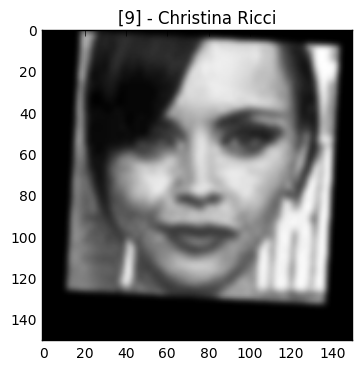

In [13]:
## Loading the modified CNN model
model_mod = load_model('model_CNNModV1.h5')

## Loading face cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

## Reading the image
test_img, img_label = image_pipeline(img_path)

## Decoding the label
enc_img_label = le.transform([img_label])

## Plotting the test image along with its associated label
test_img_exp = np.reshape(test_img,[150,150])
plt.imshow(test_img_exp, cmap = 'gray')
plt.title(str(enc_img_label)+' - '+img_label)

In [14]:
## Predcting the label for the image using the model
preds = model_mod.predict(test_img)
enc_label = np.argmax(preds, axis = 1)
label = le.inverse_transform(enc_label)
print(str(enc_label),' - ',label)


[9]  -  ['Christina Ricci']


In [15]:
preda = list(preds.flatten())
max_val = max(preda)
max_idx = preda.index(max_val)
print(preds)
print(max_idx, max_val)

[[  3.81800555e-06   6.99779662e-07   1.20584574e-03   3.55117518e-04
    3.16629230e-05   1.41965734e-06   8.75221085e-05   4.22841331e-05
    1.00011516e-06   5.05398691e-01   2.67290543e-05   1.28049978e-05
    1.45686599e-05   7.35804178e-07   3.71868846e-05   2.99825217e-04
    1.43312186e-03]]
9 0.505399


## Testing the models using all images in 'test_images' folder

In [16]:
def accuracy_test(list_dir, model):
    acc_arr = []
    enc_img_label_arr = []
    enc_label_arr = []
    
    for file in list_testdir:
        # Sending the model to the image pipeline
        test_img, img_label = image_pipeline(file)

        if len(test_img):
            # If test_img successfully found, ...
            # Decode its label
            enc_img_label = le.transform([img_label])

            # Predicting its label
            preds = model.predict(test_img)
            enc_label = np.argmax(preds, axis = 1)

            # Appending values to separate arrays for later analysis
            enc_img_label_arr.append(int(enc_img_label))
            enc_label_arr.append(int(enc_label))
            acc_arr.append(int(enc_img_label) == int(enc_label) )
            
    print('Accuracy Score: ',accuracy_score(enc_img_label_arr, enc_label_arr))
    print('F1 Score: ',f1_score(enc_img_label_arr, enc_label_arr, average='weighted'))

## Testing Modified CNN model on test_images

In [17]:
list_testdir = list_files('test_images')

# Loading the Modified CNN Model
model_mod = load_model('model_CNNModV1.h5')
accuracy_test(list_testdir, model_mod)

Accuracy Score:  0.781818181818


C:\Users\anish_4s67ibh\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 Score:  0.832814438754


## Testing Base CNN model on test_images

In [18]:
list_testdir = list_files('test_images')

# Loading the Modified CNN Model
model_base = load_model('modelV3.h5')
accuracy_test(list_testdir, model_base)

Accuracy Score:  0.775757575758


C:\Users\anish_4s67ibh\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 Score:  0.82192394021


### Recognizing faces in a video

In [25]:
def random_color():
    
    color_scale = [0,0,0];
    
    rand_int = random.randint(0,2)
    rand_int1 = random.randint(0,1)
    if rand_int1:
        color_scale[rand_int] = 255
        color_scale = tuple(color_scale)
    else:
        rand_col1 = random.choice([0, 150, 255])
        rand_col2 = random.choice([0, 150, 255])
        rand_col3 = random.choice([0, 150, 255])
        color_scale =  (rand_col1, rand_col2, rand_col3)
    
    return color_scale
    
    
def video_pipeline(img):
    output_img = []
        
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ## Detecting faces and cropping
    faces = face_cascade.detectMultiScale(gray, 1.3, 2)
    if len(faces):
        for (x,y,w,h) in faces:
            try:
                # Image processing
                cropped_img =  img[y:y+h, x:x+w]
                output_img = process_image(cropped_img)
            except:
                continue
                
            # Prediction
            preds = model_mod.predict(output_img)
            predicted = list(preds.flatten())
            max_val = max(predicted)
            max_idx = predicted.index(max_val)
            
            if max_val > 0.3:
                label = le.inverse_transform(max_idx)
            else:
                label = ''
            
            ## image dimensions
            img_width = np.shape(img)[1]
            
            ## Drawing rectangle and adding label
            rand_color = random_color()
            cv2.rectangle(img, (x, y), (x + w, y + h), (0,0,255) , int(img_width/130))
            cv2.rectangle(img, (x, y+h - 5), (x+w , y+h), (0,0,255) , cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(img, label, (x , y+h ), font, img_width/1300, (0, 0, 0), int(img_width/330))
            #cv2.putText(img, label, (x + 6, y - 6), font, 1.0, (255, 255, 255), 1)

    return img
            

test_images\Cristiano Ronaldo\ronaldo-vs-messi.jpg


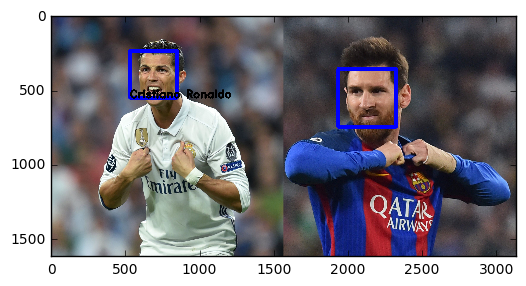

In [26]:
## Testing Video Pipeline
test_folder = 'test_images' 
label_folder  = 'Cristiano Ronaldo'
name = 'ronaldo-vs-messi.jpg'

img_path = os.path.join(test_folder, label_folder , name)

inp =  mpimg.imread(img_path)
outp = video_pipeline(inp)
print(img_path)

plt.imshow(outp)

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
#car_class=car()
veh_det_output = 'facial_recog_proj_soln.mp4'


clip1 = VideoFileClip("facial_recog_proj.mp4")
white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(veh_det_output, audio=False)

[MoviePy] >>>> Building video facial_recog_proj_soln.mp4
[MoviePy] Writing video facial_recog_proj_soln.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 2137/2137 [09:05<00:00,  3.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: facial_recog_proj_soln.mp4 

Wall time: 9min 5s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(veh_det_output))

In [30]:
all_labels

['Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Abhishek Bachan',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodriguez',
 'Alex Rodr

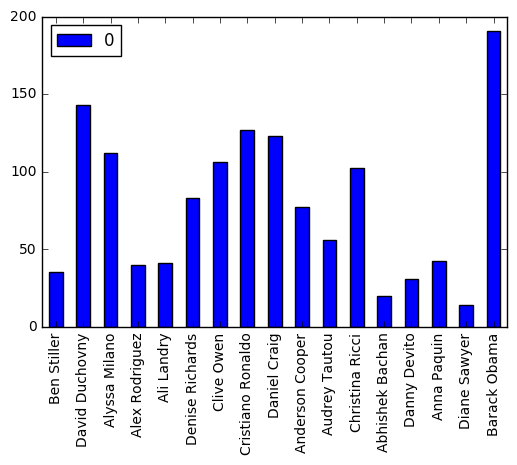

In [31]:
import pandas
from collections import Counter
a = ['a', 'a', 'a', 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'e', 'e', 'e', 'e', 'e']
label_counts = Counter(all_labels)
df = pandas.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar')